# FLDetector for MNIST with Fang/Dirichlet distributions

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/scratch/gypsum-gpu067/6138700/ipykernel_1680552/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import random
import copy
import time
from functools import reduce

import os
import sys
import pickle
sys.path.insert(0,'./utils/')
from logger import *
from eval import *
from misc import *

from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

from SGD import *
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
def sample_dirichlet_train_data(trainset, no_participants, alpha=0.9, force=False):
        """
            Input: Number of participants and alpha (param for distribution)
            Output: A list of indices denoting data in CIFAR training set.
            Requires: cifar_classes, a preprocessed class-indice dictionary.
            Sample Method: take a uniformly sampled 10-dimension vector as parameters for
            dirichlet distribution to sample number of images in each class.
        """
        if not os.path.exists('./dirichlet_a_%.1f_nusers_%d.pkl'%(alpha, no_participants)) or force:
            print('generating participant indices for alpha %.1f'%alpha)
            np.random.seed(0)
            cifar_classes = {}
            for ind, x in enumerate(trainset):
                _, label = x
                if label in cifar_classes:
                    cifar_classes[label].append(ind)
                else:
                    cifar_classes[label] = [ind]

            per_participant_list = defaultdict(list)
            no_classes = len(cifar_classes.keys())
            for n in range(no_classes):
                random.shuffle(cifar_classes[n])
                sampled_probabilities = len(cifar_classes[n]) * np.random.dirichlet(
                    np.array(no_participants * [alpha]))
                for user in range(no_participants):
                    no_imgs = int(round(sampled_probabilities[user]))
                    sampled_list = cifar_classes[n][:min(len(cifar_classes[n]), no_imgs)]
                    per_participant_list[user].extend(sampled_list)
                    cifar_classes[n] = cifar_classes[n][min(len(cifar_classes[n]), no_imgs):]
            with open('./dirichlet_a_%.1f_nusers_%d.pkl'%(alpha, no_participants), 'wb') as f:
                pickle.dump(per_participant_list, f)
        else:
            per_participant_list = pickle.load(open('./dirichlet_a_%.1f_nusers_%d.pkl'%(alpha, no_participants), 'rb'))
            
        return per_participant_list

In [4]:
def get_client_train_data(trainset, num_workers=100, bias=0.5):
    np.random.seed(0)
    bias_weight = bias
    other_group_size = (1 - bias_weight) / 9.
    worker_per_group = num_workers / 10

    each_worker_data = [[] for _ in range(num_workers)]
    each_worker_label = [[] for _ in range(num_workers)]
    
    for i, (x, y) in enumerate(trainset):
        # assign a data point to a group
        upper_bound = (y) * (1 - bias_weight) / 9. + bias_weight
        lower_bound = (y) * (1 - bias_weight) / 9.
        rd = np.random.random_sample()

        if rd > upper_bound:
            worker_group = int(np.floor((rd - upper_bound) / other_group_size) + y + 1)
        elif rd < lower_bound:
            worker_group = int(np.floor(rd / other_group_size))
        else:
            worker_group = y

        rd = np.random.random_sample()
        selected_worker = int(worker_group * worker_per_group + int(np.floor(rd * worker_per_group)))
        
        if not len(each_worker_data[selected_worker]):
            each_worker_data[selected_worker] = x[None, :]
        else:
            each_worker_data[selected_worker]= torch.concat((each_worker_data[selected_worker], x[None, :]))
        
        each_worker_label[selected_worker].append(y)
    
    each_worker_tr_data = [[] for _ in range(num_workers)]
    each_worker_tr_label = [[] for _ in range(num_workers)]
    each_worker_te_data = [[] for _ in range(num_workers)]
    each_worker_te_label = [[] for _ in range(num_workers)]
    
    for i in range(num_workers):
        w_len = len(each_worker_data[i])
        len_tr = int(6 * w_len / 7)
        len_te = w_len - len_tr
        tr_idx = np.random.choice(w_len, len_tr, replace=False)
        te_idx = np.delete(np.arange(w_len), tr_idx)
        each_worker_tr_data[i] = each_worker_data[i][tr_idx]
        each_worker_tr_label[i] = torch.Tensor(each_worker_label[i])[tr_idx]
        
        each_worker_te_data[i] = each_worker_data[i][te_idx]
        each_worker_te_label[i] = torch.Tensor(each_worker_label[i])[te_idx]
        
    global_test_data = torch.concat(each_worker_te_data)
    global_test_label = torch.concat(each_worker_te_label)
    del each_worker_data, each_worker_label
    return each_worker_tr_data, each_worker_tr_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label

In [5]:
def get_client_data_dirichlet(trainset, num_workers, alpha=1, force=False):
    per_participant_list = sample_dirichlet_train_data(trainset, num_workers, alpha=alpha, force=force)
    
    each_worker_data = [[] for _ in range(num_workers)]
    each_worker_label = [[] for _ in range(num_workers)]
    
    each_worker_te_data = [[] for _ in range(num_workers)]
    each_worker_te_label = [[] for _ in range(num_workers)]
    
    np.random.seed(0)
    for worker_idx in range(len(per_participant_list)):
        w_indices = np.array(per_participant_list[worker_idx])
        w_len = len(w_indices)
        len_tr = int(6*w_len/7)
        len_te = w_len - len_tr
        tr_idx = np.random.choice(w_len, len_tr, replace=False)
        te_idx = np.delete(np.arange(w_len), tr_idx)
        
        for idx in tr_idx:
            each_worker_data[worker_idx].append(trainset[idx][0])
            each_worker_label[worker_idx].append(trainset[idx][1])
        each_worker_data[worker_idx] = torch.stack(each_worker_data[worker_idx])
        each_worker_label[worker_idx] = torch.Tensor(each_worker_label[worker_idx]).long()
        
        for idx in te_idx:
            each_worker_te_data[worker_idx].append(trainset[idx][0])
            each_worker_te_label[worker_idx].append(trainset[idx][1])
        each_worker_te_data[worker_idx] = torch.stack(each_worker_te_data[worker_idx])
        each_worker_te_label[worker_idx] = torch.Tensor(each_worker_te_label[worker_idx]).long()
    
    global_test_data = torch.concat(each_worker_te_data)
    global_test_label = torch.concat(each_worker_te_label)
    
    return each_worker_data, each_worker_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label


In [6]:
def full_trim(v, f):
    '''
    Full-knowledge Trim attack. w.l.o.g., we assume the first f worker devices are compromised.
    v: the list of squeezed gradients
    f: the number of compromised worker devices
    '''
    vi_shape = v[0].unsqueeze(0).T.shape
    v_tran = v.T
    
    maximum_dim = torch.max(v_tran, dim=1)
    maximum_dim = maximum_dim[0].reshape(vi_shape)
    minimum_dim = torch.min(v_tran, dim=1)
    minimum_dim = minimum_dim[0].reshape(vi_shape)
    direction = torch.sign(torch.sum(v_tran, dim=-1, keepdims=True))
    directed_dim = (direction > 0) * minimum_dim + (direction < 0) * maximum_dim

    for i in range(f):
        random_12 = 2
        tmp = directed_dim * ((direction * directed_dim > 0) / random_12 + (direction * directed_dim < 0) * random_12)
        tmp = tmp.squeeze()
        v[i] = tmp
    return v

In [7]:
def tr_mean(all_updates, n_attackers):
    sorted_updates = torch.sort(all_updates, 0)[0]
    out = torch.mean(sorted_updates[n_attackers:-n_attackers], 0) if n_attackers else torch.mean(sorted_updates,0)
    return out

In [3]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 50, 5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
fed_model = cnn().cuda()
model_received = []
for i, (name, param) in enumerate(fed_model.state_dict().items()):
    model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(
        model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))
print(f'Number of model params is {len(model_received)}')

Number of model params is 453572


In [15]:
from sklearn.metrics import roc_auc_score
def fldetector(old_gradients, user_grads, b=0, hvp=None, agr='tr_mean'):
    if hvp is not None:
        hvp = torch.from_numpy(hvp).to(device)
        pred_grad = copy.deepcopy(old_gradients)
        distance = []
        for i in range(len(old_gradients)):
            pred_grad[i] += hvp
        pred = np.zeros(100)
        pred[:b] = 1
        distance = torch.norm(pred_grad - user_grads, dim = 1).cpu().numpy()
        distance = distance / np.sum(distance)
    else:
        distance = None
    
    if agr == 'average':
        agg_grads = torch.mean(user_grads, 0)
    elif agr == 'median':
        agg_grads = torch.median(user_grads, 0)[0]
    elif agr == 'tr_mean':
        agg_grads = tr_mean(user_grads, b)
    return agg_grads, distance

def lbfgs(S_k_list, Y_k_list, v):
    curr_S_k = torch.stack(S_k_list).T
    curr_Y_k = torch.stack(Y_k_list).T
    S_k_time_Y_k = np.dot(curr_S_k.T.cpu().numpy(), curr_Y_k.cpu().numpy())
    S_k_time_S_k = np.dot(curr_S_k.T.cpu().numpy(), curr_S_k.cpu().numpy())
    R_k = np.triu(S_k_time_Y_k)
    L_k = S_k_time_Y_k - R_k
    sigma_k = np.dot(Y_k_list[-1].unsqueeze(0).cpu().numpy(), S_k_list[-1].unsqueeze(0).T.cpu().numpy()) / (np.dot(S_k_list[-1].unsqueeze(0).cpu().numpy(), S_k_list[-1].unsqueeze(0).T.cpu().numpy()))
    D_k_diag = np.diag(S_k_time_Y_k)
    upper_mat = np.concatenate((sigma_k * S_k_time_S_k, L_k), axis=1)
    lower_mat = np.concatenate((L_k.T, -np.diag(D_k_diag)), axis=1)
    mat = np.concatenate((upper_mat, lower_mat), axis=0)
    mat_inv = np.linalg.inv(mat)

    approx_prod = sigma_k * v.cpu().numpy()
    approx_prod = approx_prod.T
    p_mat = np.concatenate((np.dot(curr_S_k.T.cpu().numpy(), sigma_k * v.unsqueeze(0).T.cpu().numpy()), np.dot(curr_Y_k.T.cpu().numpy(), v.unsqueeze(0).T.cpu().numpy())), axis=0)
    approx_prod -= np.dot(np.dot(np.concatenate((sigma_k * curr_S_k.cpu().numpy(), curr_Y_k.cpu().numpy()), axis=1), mat_inv), p_mat)

    return approx_prod

def detection(score, nobyz, nworkers):
    estimator = KMeans(n_clusters=2)
    estimator.fit(score.reshape(-1, 1))
    label_pred = estimator.labels_
    if np.mean(score[label_pred==0])<np.mean(score[label_pred==1]):
        #0 is the label of malicious clients
        label_pred = 1 - label_pred
    real_label=np.ones(nworkers)
    real_label[:nobyz]=0
    acc=len(label_pred[label_pred==real_label])/nworkers
    recall=1-np.sum(label_pred[:nobyz])/nobyz
    fpr=1-np.sum(label_pred[nobyz:])/(nworkers-nobyz)
    fnr=np.sum(label_pred[:nobyz])/nobyz
    try:
        auc = roc_auc_score(real_label, label_pred)
    except:
        auc = -1
    print("acc %0.4f; recall %0.4f; fpr %0.4f; fnr %0.4f; auc %.4f" % (acc, recall, fpr, fnr, auc))
    return acc, fpr, fnr, auc
    # print(silhouette_score(score.reshape(-1, 1), label_pred))

def detection1(score, nobyz):
    nrefs = 10
    ks = range(1, 8)
    gaps = np.zeros(len(ks))
    gapDiff = np.zeros(len(ks) - 1)
    sdk = np.zeros(len(ks))
    min = np.min(score)
    max = np.max(score)
    score = (score - min)/(max-min)
    for i, k in enumerate(ks):
        estimator = KMeans(n_clusters=k)
        estimator.fit(score.reshape(-1, 1))
        label_pred = estimator.labels_
        center = estimator.cluster_centers_
        Wk = np.sum([np.square(score[m]-center[label_pred[m]]) for m in range(len(score))])
        WkRef = np.zeros(nrefs)
        for j in range(nrefs):
            rand = np.random.uniform(0, 1, len(score))
            estimator = KMeans(n_clusters=k)
            estimator.fit(rand.reshape(-1, 1))
            label_pred = estimator.labels_
            center = estimator.cluster_centers_
            WkRef[j] = np.sum([np.square(rand[m]-center[label_pred[m]]) for m in range(len(rand))])
        gaps[i] = np.log(np.mean(WkRef)) - np.log(Wk)
        sdk[i] = np.sqrt((1.0 + nrefs) / nrefs) * np.std(np.log(WkRef))

        if i > 0:
            gapDiff[i - 1] = gaps[i - 1] - gaps[i] + sdk[i]
    #print(gapDiff)
    for i in range(len(gapDiff)):
        if gapDiff[i] >= 0:
            select_k = i+1
            break
    if select_k == 1:
        return 0
    else:
        # print('Attack Detected!')
        return 1

In [10]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def train(train_data, labels, model, optimizer, batch_size=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = AverageMeter()
    top1 = AverageMeter()
    len_t = (len(train_data) // batch_size)
    if len(train_data)%batch_size:
        len_t += 1
    r=np.arange(len(train_data))
    np.random.shuffle(r)
    train_data = train_data[r]
    labels = labels[r]
    for ind in range(len_t):
        inputs = train_data[ind * batch_size:(ind + 1) * batch_size].cuda()
        targets = labels[ind * batch_size:(ind + 1) * batch_size].cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return (losses.avg, top1.avg)


def test(test_data, labels, model, criterion, use_cuda, debug_='MEDIUM', batch_size=64):
    losses = AverageMeter()
    top1 = AverageMeter()
    model.eval()
    len_t = (len(test_data) // batch_size)
    if len(test_data)%batch_size:
        len_t += 1
    with torch.no_grad():
        for ind in range(len_t):
            inputs = test_data[ind * batch_size:(ind + 1) * batch_size].cuda()
            targets = labels[ind * batch_size:(ind + 1) * batch_size].cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
    return (losses.avg, top1.avg)

In [17]:
all_data = torch.utils.data.ConcatDataset((trainset, testset))
num_workers = 100
distribution='fang'
param = .5
force = True

if distribution=='fang':
    each_worker_data, each_worker_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label = get_client_train_data(all_data, num_workers=100, bias=param)
elif distribution == 'dirichlet':
    each_worker_data, each_worker_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label = get_client_data_dirichlet(all_data, num_workers, alpha=param, force=force)

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

# Histogram of number of samples / client for Fang and Dirichlet distributions

(array([30., 21., 15., 13.,  7.,  3.,  4.,  1.,  3.,  3.]),
 array([   3. ,  227.2,  451.4,  675.6,  899.8, 1124. , 1348.2, 1572.4,
        1796.6, 2020.8, 2245. ]),
 <BarContainer object of 10 artists>)

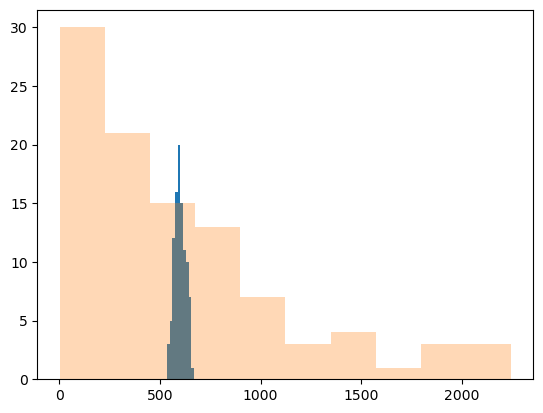

In [20]:
d_lens_dirichlet = [len(d) for d in each_worker_data]
plt.hist(d_lens)
plt.hist(d_lens_dirichlet, alpha=.3)

# Fast baseline results

# MNIST + some client with noisy Labels

In [16]:
'''
FAST BASELINE
'''
n_malicious = [10]

for n_mal in n_malicious:
    torch.cuda.empty_cache()
    try:
        # delete all variables
        del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
        del good_distance_rage
        del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
        del attack_type, dev_type, fed_model
    except:
        pass
    
    # FL training initializations
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=0.01
    local_batch_size=32
    local_epochs=2
    global_lr=1
    agr='tr_mean' # ['average', 'median', 'tr_mean']

    # Attack initializations
    attack_type = 'none'
    dev_type = 'sign'
    nbyz = n_mal

    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, num_workers))
    start_detection_epoch = 5
    window_size = 5
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0
    

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    model_received = []
    for i, (name, param) in enumerate(fed_model.state_dict().items()):
        model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))

    for e in range(50):
        user_grads=[]
        round_clients = np.arange(num_workers)
        round_benign = round_clients
        user_grads=[]

        for i in round_benign:
            model = copy.deepcopy(fed_model)
            optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
            if i < n_mal:
                for epoch in range(local_epochs):
                    train_loss, train_acc = train(
                        each_worker_data[i].reshape(-1, 1, 28, 28),
                        torch.Tensor((np.random.choice(10)+each_worker_label[i])%10).long(), model, optimizer, local_batch_size)
            else:
                for epoch in range(local_epochs):
                    train_loss, train_acc = train(
                        each_worker_data[i].reshape(-1, 1, 28, 28),
                        torch.Tensor(each_worker_label[i]).long(), model, optimizer, local_batch_size)

            params = []
            for i, (name, param) in enumerate(model.state_dict().items()):
                params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                    (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

            update =  (params - model_received)
            user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

        weight = model_received

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
            # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'LIE':
                    z = 0.1
                    noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                    noise_std = torch.std(user_grads[:nbyz], dim=0)
                    noise = noise_avg + z * noise_std
                elif attack_type == 'NDSS21':
                    distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        model_received = model_received + global_lr * agg_grads
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        start_idx=0
        state_dict = {}
        previous_name = 'none'
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
            start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
            params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
            state_dict[name] = params
            previous_name = name

        fed_model.load_state_dict(state_dict)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%5==0 or e==99:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 1.537 val acc 74.061 | best val_acc 74.061
e 5 | val_loss 0.168 val acc 95.229 | best val_acc 95.229
Stop at iteration: 10
acc 1.0000; recall 1.0000; fpr 0.0000; fnr 0.0000; auc 1.0000


# MNIST + some clients with feature noise

In [18]:
'''
FAST BASELINE
'''
n_malicious = [10]

for n_mal in n_malicious:
    torch.cuda.empty_cache()
    try:
        # delete all variables
        del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
        del good_distance_rage
        del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
        del attack_type, dev_type, fed_model
    except:
        pass

    # FL training initializations
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=0.01
    local_batch_size=32
    local_epochs=2
    global_lr=1
    nepochs=50
    agr='tr_mean' # ['average', 'median', 'tr_mean']

    # Attack initializations
    attack_type = 'none'
    dev_type = 'sign'
    nbyz = n_mal

    # Noisy MNIST initializations
    noisy_mnist = 10
    beta = 1.0
    nbyz = noisy_mnist
    noisy_mnist_data = []
    for i in range(noisy_mnist):
        d = copy.deepcopy(each_worker_data[i])
        d = (1 - beta) * d + beta * torch.normal(mean = torch.zeros(d.shape), std=1e-1*torch.ones(d.shape))
        noisy_mnist_data.append(d)
    print('noisy_mnist_data len: ', len(noisy_mnist_data))
    
    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, noisy_mnist + num_workers))
    start_detection_epoch = 5
    window_size = 5
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    model_received = []
    for i, (name, param) in enumerate(fed_model.state_dict().items()):
        model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))
    
    for e in range(nepochs):
        user_grads=[]
        round_clients = np.arange(noisy_mnist + num_workers)
        round_benign = round_clients
        user_grads=[]

        for i in round_benign:
            model = copy.deepcopy(fed_model)
            optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
            if i < noisy_mnist:
                for epoch in range(local_epochs):
                    train_loss, train_acc = train(
                        noisy_mnist_data[i].reshape(-1, 1, 28, 28),
                        torch.Tensor(each_worker_label[i]).long(), model, optimizer, local_batch_size)
            else:
                for epoch in range(local_epochs):
                    train_loss, train_acc = train(
                        each_worker_data[i - noisy_mnist].reshape(-1, 1, 28, 28),
                        torch.Tensor(each_worker_label[i - noisy_mnist]).long(),
                        model, optimizer, local_batch_size)

            params = []
            for i, (name, param) in enumerate(model.state_dict().items()):
                params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                    (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

            update =  (params - model_received)
            user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

        if e == 0:
            print('user grads shape: ', user_grads.shape)

        weight = model_received

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'LIE':
                    z = 0.1
                    noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                    noise_std = torch.std(user_grads[:nbyz], dim=0)
                    noise = noise_avg + z * noise_std
                elif attack_type == 'NDSS21':
                    distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        model_received = model_received + global_lr * agg_grads
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        start_idx=0
        state_dict = {}
        previous_name = 'none'
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
            start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
            params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
            state_dict[name] = params
            previous_name = name

        fed_model.load_state_dict(state_dict)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%5==0 or e==nepochs-1:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

noisy_mnist_data len:  10
user grads shape:  torch.Size([110, 453572])
e 0 | val_loss 1.758 val acc 67.786 | best val_acc 67.786
e 5 | val_loss 0.185 val acc 94.452 | best val_acc 94.452
e 10 | val_loss 0.124 val acc 96.225 | best val_acc 96.225
e 20 | val_loss 0.085 val acc 97.450 | best val_acc 97.450
e 25 | val_loss 0.076 val acc 97.619 | best val_acc 97.619
e 30 | val_loss 0.070 val acc 97.828 | best val_acc 97.838
e 35 | val_loss 0.064 val acc 97.998 | best val_acc 97.998
Stop at iteration: 38


/scratch/gypsum-gpu122/4403169/ipykernel_3998100/2337786522.py:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  acc=len(label_pred[label_pred==real_label])/nworkers


ValueError: Found input variables with inconsistent numbers of samples: [100, 110]

In [19]:
detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, 110)

acc 0.9000; recall 0.0000; fpr 0.0100; fnr 1.0000; auc 0.4950


(0.9, 0.010000000000000009, 1.0, 0.495)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


# Load ARDIS data

In [12]:
import pandas as pd
d = pd.read_csv('/home/vshejwalkar_umass_edu/ardis/ARDIS_train_2828.csv', header=None)
l = pd.read_csv('/home/vshejwalkar_umass_edu/ardis/ARDIS_train_labels.csv', header=None)
ardis_data = 1-np.array([np.array(s.split(' ')).reshape(28, 28).astype(np.float32) for s in d[0]])/255
ardis_label = np.array([np.array(s.split('          ')).astype(np.int32).argmax() for s in l[0]])

d_ = pd.read_csv('/home/vshejwalkar_umass_edu/ardis/ARDIS_test_2828.csv', header=None)
l_ = pd.read_csv('/home/vshejwalkar_umass_edu/ardis/ARDIS_test_labels.csv', header=None)

te_ardis_data = 1-np.array([np.array(s.split(' ')).reshape(28, 28).astype(np.float32) for s in d_[0]])/255
te_ardis_label = np.array([np.array(s.split('          ')).astype(np.int32).argmax() for s in l_[0]])

ardis_data = np.concatenate((ardis_data, te_ardis_data))
ardis_label = np.concatenate((te_ardis_label, ardis_label))

from torch.utils.data import Dataset, DataLoader
class Ardis(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, ardis_data, ardis_label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = ardis_data
        self.labels = ardis_label
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = torch.Tensor((self.data[idx] - np.mean(self.data[idx]))/np.std(self.data[idx]))
        label = self.labels[idx]
        sample = (image, label)
        return sample

transform = transforms.Compose([transforms.ToTensor()])
ardis = Ardis(ardis_data, ardis_label, transform=transform)

In [13]:
total_num_workers_ardis = 30
num_workers_ardis = 30
num_ardis_backdoor_clients=0
distribution='fang'
param = .5
force = True
if distribution=='fang':
    ardis_each_worker_data, ardis_each_worker_label, ardis_each_worker_te_data, ardis_each_worker_te_label, ardis_global_test_data, ardis_global_test_label = get_client_train_data(
        ardis, num_workers=total_num_workers_ardis, bias=param)
elif distribution == 'dirichlet':
    ardis_each_worker_data, ardis_each_worker_label, ardis_each_worker_te_data, ardis_each_worker_te_label, ardis_global_test_data, ardis_global_test_label = get_client_data_dirichlet(
        ardis, total_num_workers_ardis, alpha=param, force=force)

In [23]:
backdoor_data = []
source_class = 7
for i in range(len(ardis)):
    if ardis[i][1] == source_class:
        backdoor_data.append(ardis[i])

backdoor_tr_data = []
backdoor_tr_labels = []
backdoor_te_data = []
backdoor_te_labels = []
for i in range(len(backdoor_data)):
    if i < 700:
        backdoor_tr_data.append(backdoor_data[i][0])
        backdoor_tr_labels.append(backdoor_data[i][1])
    else:
        backdoor_te_data.append(backdoor_data[i][0])
        backdoor_te_labels.append(backdoor_data[i][1])

In [26]:
len(backdoor_te_data)

60

In [21]:
'''
FAST --AVERAGE-- BASELINE
'''
n_malicious = [0]
for run in range(3):
    print('\n====> run %d' % run)
    for n_mal in n_malicious:
        torch.cuda.empty_cache()
        try:
            # delete all variables
            del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
            del good_distance_rage
            del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
            del attack_type, dev_type, fed_model
        except:
            pass

        # FL training initializations
        num_workers = 100
        use_cuda = True
        criterion = nn.CrossEntropyLoss()
        local_lr=0.01
        local_batch_size=32
        local_epochs=2
        global_lr=1
        nepochs=50
        agr='average' # ['average', 'median', 'tr_mean']

        # Attack initializations
        num_ardis_backdoor_clients = 0

        attack_type = 'none'
        dev_type = 'sign'
        nbyz = num_workers_ardis

        # FLD initializations
        weight_record = []
        grad_record = []
        old_grad_list = []
        malicious_scores = np.zeros((1, num_workers_ardis + num_workers))
        start_detection_epoch = 5
        window_size = 5
        assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
        good_distance_rage = np.zeros((1, nbyz))
        best_val_acc = 0.0

        # FL model initializations
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        model_received = []
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))

        for e in range(nepochs):
            user_grads=[]
            round_clients = np.arange(num_workers_ardis + num_workers)
            round_benign = round_clients
            user_grads=[]

            for i in round_benign:
                model = copy.deepcopy(fed_model)
                optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
                if i < num_workers_ardis:
                    for epoch in range(local_epochs):
                        train_loss, train_acc = train(
                            ardis_each_worker_data[i].reshape(-1, 1, 28, 28),
                            torch.Tensor(ardis_each_worker_label[i]).long(), model, optimizer, local_batch_size)
                else:
                    for epoch in range(local_epochs):
                        train_loss, train_acc = train(
                            each_worker_data[i - num_workers_ardis].reshape(-1, 1, 28, 28),
                            torch.Tensor(each_worker_label[i - num_workers_ardis]).long(),
                            model, optimizer, local_batch_size)

                params = []
                for i, (name, param) in enumerate(model.state_dict().items()):
                    params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                        (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

                update =  (params - model_received)
                user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

            if num_ardis_backdoor_clients:
                backdoor_norm = 0
                for _ in range(num_ardis_backdoor_clients):
                    r = np.arange(len(backdoor_tr_data))
                    np.random.shuffle(r)
                    backdoor_tr_len = 200
                    model = copy.deepcopy(fed_model)
                    optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
                    for epoch in range(local_epochs):
                        train_loss, train_acc = train(
                            torch.stack(backdoor_tr_data)[r][:backdoor_tr_len].reshape(-1, 1, 28, 28),
                            torch.from_numpy(np.ones(backdoor_tr_len)).long(),
                            model, optimizer, local_batch_size)
                    params = []
                    for i, (name, param) in enumerate(model.state_dict().items()):
                        params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                            (params, param.view(-1).data.type(torch.cuda.FloatTensor)))
                    update =  (params - model_received)
                    backdoor_norm += torch.norm(update)/num_ardis_backdoor_clients
                    user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

            if e == 0:
                print('user grads shape: ', user_grads.shape)

            weight = model_received
            if (e > start_detection_epoch):
                hvp = lbfgs(weight_record, grad_record, weight - last_weight)
                hvp = np.squeeze(hvp)
            else:
                hvp = None

            if attack_type != 'none':
                good_current_grads = copy.deepcopy(user_grads[:nbyz])
                if hvp is not None:
                    pred_grad = copy.deepcopy(good_old_grads)
                    distance = []
                    for i in range(len(good_old_grads)):
                        pred_grad[i] += torch.from_numpy(hvp).to(device)
                    good_distance_rage = np.concatenate(
                        (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

            if attack_type != 'none' and (e < start_detection_epoch):
                user_grads = full_trim(user_grads, nbyz)
            elif e > start_detection_epoch:
                if attack_type == 'full_trim':
                    user_grads = full_trim(user_grads, nbyz)
                elif attack_type == 'none':
                    pass
                else:
                    if attack_type == 'LIE':
                        z = 0.1
                        noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                        noise_std = torch.std(user_grads[:nbyz], dim=0)
                        noise = noise_avg + z * noise_std
                    elif attack_type == 'NDSS21':
                        distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                        model_re = torch.mean(good_current_grads, dim=0)
                        if dev_type == 'unit_vec':
                            deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                        elif dev_type == 'sign':
                            deviation = torch.sign(model_re)
                        elif dev_type == 'std':
                            deviation = torch.std(good_current_grads, 0)
                        # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                        noise = deviation * ((distance_bound)) / torch.norm(deviation)
                    else:
                        noise = torch.zeros(hvp.shape).to(device)
                    for m in range(nbyz):
                        user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

            agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

            if distance is not None and e > (start_detection_epoch - window_size):
                malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

            if malicious_scores.shape[0] >= window_size+1:
                if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                    print('Stop at iteration:', e)
                    detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, len(user_grads))
                    break

            if e > (start_detection_epoch - window_size):
                weight_record.append(weight - last_weight)
                grad_record.append(agg_grads - last_grad)

            if (len(weight_record) > window_size):
                del weight_record[0]
                del grad_record[0]

            last_weight = weight
            last_grad = agg_grads
            old_grad_list = user_grads
            if attack_type != 'none':
                good_old_grads = good_current_grads

            del user_grads
            model_received = model_received + global_lr * agg_grads
            fed_model = cnn().to(device)
            fed_model.apply(init_weights)
            start_idx=0
            state_dict = {}
            previous_name = 'none'
            for i, (name, param) in enumerate(fed_model.state_dict().items()):
                start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
                start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
                params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
                state_dict[name] = params
                previous_name = name

            fed_model.load_state_dict(state_dict)
            val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
            ardis_loss, ardis_acc = test(ardis_global_test_data.reshape(-1,1,28,28), ardis_global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
            is_best = best_val_acc < val_acc
            best_val_acc = max(best_val_acc, val_acc)
            if e%5==0 or e==nepochs-1:
                print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f | ardis loss %.3f acc %.3f' % (
                    e, val_loss, val_acc, best_val_acc, ardis_loss, ardis_acc))


====> run 0
user grads shape:  torch.Size([130, 453572])
e 0 | val_loss 1.685 val acc 72.119 | best val_acc 72.119 | ardis loss 2.287 acc 11.749
e 5 | val_loss 0.198 val acc 94.820 | best val_acc 94.820 | ardis loss 2.168 acc 20.583
e 10 | val_loss 0.131 val acc 96.065 | best val_acc 96.065 | ardis loss 1.921 acc 28.780
e 15 | val_loss 0.105 val acc 96.693 | best val_acc 96.693 | ardis loss 1.753 acc 33.151
e 20 | val_loss 0.090 val acc 97.181 | best val_acc 97.181 | ardis loss 1.648 acc 36.885
e 25 | val_loss 0.081 val acc 97.500 | best val_acc 97.500 | ardis loss 1.577 acc 39.982
e 30 | val_loss 0.074 val acc 97.639 | best val_acc 97.639 | ardis loss 1.524 acc 40.984
e 35 | val_loss 0.069 val acc 97.838 | best val_acc 97.838 | ardis loss 1.485 acc 42.077
e 40 | val_loss 0.064 val acc 97.958 | best val_acc 97.968 | ardis loss 1.452 acc 42.623
e 45 | val_loss 0.061 val acc 98.028 | best val_acc 98.048 | ardis loss 1.427 acc 43.352
e 49 | val_loss 0.058 val acc 98.157 | best val_acc 98

In [29]:
'''
FAST --AVERAGE-- BASELINE
'''
n_malicious = [0]
for run in range(3):
    print('\n====> run %d' % run)
    for n_mal in n_malicious:
        torch.cuda.empty_cache()
        try:
            # delete all variables
            del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
            del good_distance_rage
            del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
            del attack_type, dev_type, fed_model
        except:
            pass

        # FL training initializations
        num_workers = 100
        use_cuda = True
        criterion = nn.CrossEntropyLoss()
        local_lr=0.01
        local_batch_size=32
        local_epochs=2
        global_lr=1
        nepochs=50
        agr='average' # ['average', 'median', 'tr_mean']

        # Attack initializations
        num_ardis_backdoor_clients = 5

        attack_type = 'none'
        dev_type = 'sign'
        nbyz = num_ardis_backdoor_clients

        # FLD initializations
        weight_record = []
        grad_record = []
        old_grad_list = []
        malicious_scores = np.zeros((1, (num_ardis_backdoor_clients + num_workers_ardis + num_workers)))
        start_detection_epoch = 5
        window_size = 5
        assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
        good_distance_rage = np.zeros((1, nbyz))
        best_val_acc = 0.0

        # FL model initializations
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        model_received = []
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))

        for e in range(nepochs):
            user_grads=[]
            round_clients = np.arange(num_workers_ardis + num_workers)
            round_benign = round_clients
            user_grads=[]

            if num_ardis_backdoor_clients:
                backdoor_norm = 0
                for _ in range(num_ardis_backdoor_clients):
                    r = np.arange(len(backdoor_tr_data))
                    np.random.shuffle(r)
                    backdoor_tr_len = 200
                    model = copy.deepcopy(fed_model)
                    optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
                    for epoch in range(local_epochs):
                        train_loss, train_acc = train(
                            torch.stack(backdoor_tr_data)[r][:backdoor_tr_len].reshape(-1, 1, 28, 28),
                            torch.from_numpy(np.ones(backdoor_tr_len)).long(),
                            model, optimizer, local_batch_size)
                    params = []
                    for i, (name, param) in enumerate(model.state_dict().items()):
                        params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                            (params, param.view(-1).data.type(torch.cuda.FloatTensor)))
                    update =  (params - model_received)
                    backdoor_norm += torch.norm(update)/num_ardis_backdoor_clients
                    user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

            for i in round_benign:
                model = copy.deepcopy(fed_model)
                optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
                if i < num_workers_ardis:
                    for epoch in range(local_epochs):
                        train_loss, train_acc = train(
                            ardis_each_worker_data[i].reshape(-1, 1, 28, 28),
                            torch.Tensor(ardis_each_worker_label[i]).long(), model, optimizer, local_batch_size)
                else:
                    for epoch in range(local_epochs):
                        train_loss, train_acc = train(
                            each_worker_data[i - num_workers_ardis].reshape(-1, 1, 28, 28),
                            torch.Tensor(each_worker_label[i - num_workers_ardis]).long(),
                            model, optimizer, local_batch_size)

                params = []
                for i, (name, param) in enumerate(model.state_dict().items()):
                    params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                        (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

                update =  (params - model_received)
                user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

            if e == 0:
                print('user grads shape: ', user_grads.shape)

            weight = model_received
            if (e > start_detection_epoch):
                hvp = lbfgs(weight_record, grad_record, weight - last_weight)
                hvp = np.squeeze(hvp)
            else:
                hvp = None

            good_current_grads = copy.deepcopy(user_grads[:nbyz])
            if hvp is not None:
                pred_grad = copy.deepcopy(good_old_grads)
                distance = []
                for i in range(len(good_old_grads)):
                    pred_grad[i] += torch.from_numpy(hvp).to(device)
                good_distance_rage = np.concatenate(
                    (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

            if attack_type != 'none' and (e < start_detection_epoch):
                user_grads = full_trim(user_grads, nbyz)
                # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
            elif e > start_detection_epoch:
                if attack_type == 'full_trim':
                    user_grads = full_trim(user_grads, nbyz)
                elif attack_type == 'none':
                    pass
                else:
                    if attack_type == 'LIE':
                        z = 0.1
                        noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                        noise_std = torch.std(user_grads[:nbyz], dim=0)
                        noise = noise_avg + z * noise_std
                    elif attack_type == 'NDSS21':
                        distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                        model_re = torch.mean(good_current_grads, dim=0)
                        if dev_type == 'unit_vec':
                            deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                        elif dev_type == 'sign':
                            deviation = torch.sign(model_re)
                        elif dev_type == 'std':
                            deviation = torch.std(good_current_grads, 0)
                        # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                        noise = deviation * ((distance_bound)) / torch.norm(deviation)
                    else:
                        noise = torch.zeros(hvp.shape).to(device)
                    for m in range(nbyz):
                        user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

            agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

            if distance is not None and e > (start_detection_epoch - window_size):
                malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

            if malicious_scores.shape[0] >= window_size+1:
                if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                    print('Stop at iteration:', e)
                    detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, len(user_grads))
                    break

            if e > (start_detection_epoch - window_size):
                weight_record.append(weight - last_weight)
                grad_record.append(agg_grads - last_grad)

            if (len(weight_record) > window_size):
                del weight_record[0]
                del grad_record[0]

            last_weight = weight
            last_grad = agg_grads
            old_grad_list = user_grads
            good_old_grads = good_current_grads

            del user_grads
            model_received = model_received + global_lr * agg_grads
            fed_model = cnn().to(device)
            fed_model.apply(init_weights)
            start_idx=0
            state_dict = {}
            previous_name = 'none'
            for i, (name, param) in enumerate(fed_model.state_dict().items()):
                start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
                start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
                params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
                state_dict[name] = params
                previous_name = name

            fed_model.load_state_dict(state_dict)
            val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
            ardis_loss, ardis_acc = test(ardis_global_test_data.reshape(-1,1,28,28), ardis_global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
            ardis_bd_loss, ardis_bd_acc = test(torch.stack(backdoor_te_data).reshape(-1,1,28,28), torch.from_numpy(np.ones(len(backdoor_te_data))).long(), fed_model, criterion, use_cuda, batch_size=50)
            is_best = best_val_acc < val_acc
            best_val_acc = max(best_val_acc, val_acc)
            if e%5==0 or e==nepochs-1:
                print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f | ardis loss %.3f acc %.3f | ardis backdoor loss %.3f acc %.3f' % (
                    e, val_loss, val_acc, best_val_acc, ardis_loss, ardis_acc, ardis_bd_loss, ardis_bd_acc))


====> run 0
user grads shape:  torch.Size([135, 453572])
e 0 | val_loss 1.835 val acc 73.005 | best val_acc 73.005 | ardis loss 2.317 acc 13.479 | ardis backdoor loss 1.647 acc 93.333
e 5 | val_loss 0.199 val acc 94.591 | best val_acc 94.591 | ardis loss 2.258 acc 19.672 | ardis backdoor loss 1.630 acc 53.333
Stop at iteration: 10
acc 0.7259; recall 0.0000; fpr 0.2462; fnr 1.0000; auc 0.3769

====> run 1
user grads shape:  torch.Size([135, 453572])
e 0 | val_loss 1.688 val acc 67.387 | best val_acc 67.387 | ardis loss 2.312 acc 15.118 | ardis backdoor loss 2.002 acc 38.333
e 5 | val_loss 0.229 val acc 93.495 | best val_acc 93.495 | ardis loss 2.308 acc 19.672 | ardis backdoor loss 1.774 acc 43.333
e 10 | val_loss 0.145 val acc 95.707 | best val_acc 95.707 | ardis loss 2.054 acc 26.321 | ardis backdoor loss 1.581 acc 38.333
e 15 | val_loss 0.114 val acc 96.524 | best val_acc 96.524 | ardis loss 1.909 acc 30.783 | ardis backdoor loss 1.612 acc 25.000
e 20 | val_loss 0.096 val acc 97.081